# Assignment 3
#### Lukas Hager, ECON 532
___

In [242]:
from cProfile import label
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
from scipy import optimize as op
from scipy import stats
from itertools import permutations

plt.rcParams["figure.figsize"] = (20,7)

In [11]:
source_path = '/Users/hlukas/git/uw_grad_school_code/ECON-532/Assignment 3/pset3_upload/Data/{}.dat'

## Question 1
___
We will use the formula provided in the notes, that for a button auction,
$$F_W = NF_V^{N-1} - (N-1)F_V^N$$
where $F_W$ is the distribution of the price, and $F_V$ is the distribution of the individual values. We will compute the roots of this function computationally.

In [ ]:
data_og = np.loadtxt(source_path.format('ascending_data'))

In [65]:
def get_empirical_cdf(data):
    n = len(data)
    data_sorted = np.sort(data)
    prob = np.cumsum(np.ones(n)) / n
    return(np.column_stack([data_sorted,prob]))

In [237]:
F_W = {x: get_empirical_cdf(data_og[data_og[:,0] == x][:,1]) for x in np.unique(data_og[:,0]).tolist()}
sorted_prices = np.sort(data_og[:,1])

results_dict = {x: [] for x in np.unique(data_og[:,0]).tolist()}

for dict_key in F_W.keys():
    for val in sorted_prices:
        cdf_val = empirical_cdf(F_W[dict_key], val)
        n = int(dict_key)
        roots = np.roots([-(n-1.), n*1.] + [0.] * (n-2) + [-cdf_val])
        try:
            correct_root = np.real(roots[np.where((roots <= 1.) & (roots >= 0.) & np.isreal(roots))][0].item())
        except IndexError:
            correct_root = 1.
        results_dict[dict_key].append(correct_root)

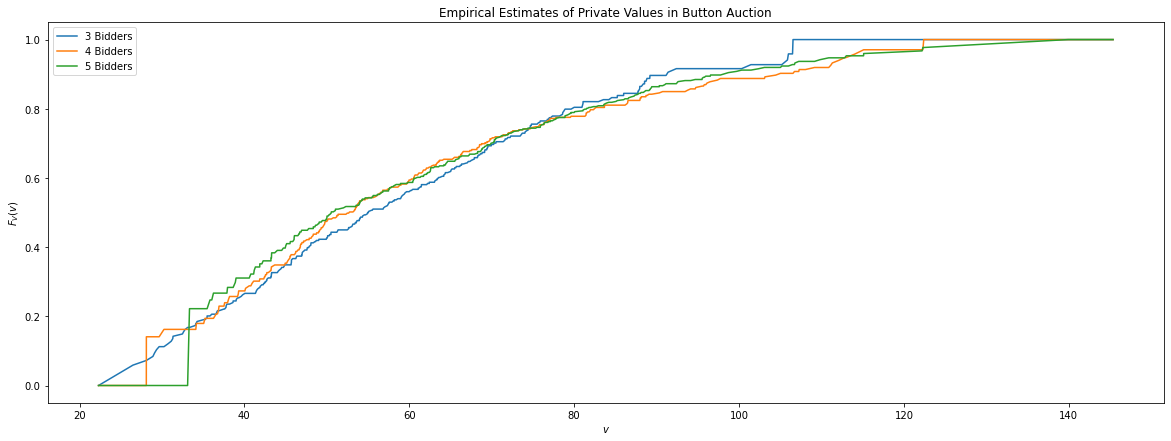

In [243]:
for dict_key in results_dict.keys():
    plt.plot(sorted_prices, results_dict[dict_key], label = '{} Bidders'.format(int(dict_key)))

plt.xlabel('$v$')
plt.ylabel('$F_V(v)$')
plt.title('Empirical Estimates of Private Values in Button Auction')
plt.legend()
plt.show()

In [44]:
# function to get nonparametric estimate of a distribution

def non_para_estim(data, x, h):
    n = len(data)
    return(np.mean(stats.norm.pdf(x, loc = data, scale = [h] * n)))

## Question 2
___
Using the notation in the lectures, as we only have the winning bids, the data that we observe are $(n, b_{n:n})$ pairs. Thus, we can estimate $\hat{G}_{n:n}$ as
$$\hat{G}_{n:n}(v) = \frac{1}{T_n}\sum_{t=1}^T\mathbb{1}\{n_t = n,b_{n:n} \leq v\}$$
In particular, given the dataset in question, we will estimate six specific distributions: $\hat{G}_{3:3}(v), \hat{G}_{4:4}(v), \hat{G}_{5:5}(v), \hat{G}_{3:3}^{\Delta}(v), \hat{G}_{4:4}^{\Delta}(v), \hat{G}_{5:5}^{\Delta}(v)$.

In [202]:
Delta = 1.

g_hat = {x: get_empirical_cdf(data_og[data_og[:,0] == x][:,1]) for x in np.unique(data_og[:,0]).tolist()}
g_delta_hat = {x: get_empirical_cdf(data_og[data_og[:,0] == x][:,1] - Delta) for x in np.unique(data_og[:,0]).tolist()}

We now move to the bounding, which requires explicit calculation of the function $\phi(\cdot)$. We only have data on $i=n$, so we have
$$F_{n:n}(v) = n\int_0^{F(v)}t^{n-1}dt = n\left[\frac{t^n}{n}\right]_0^{F(v)} = F(v)^n$$
This implies that
$$F(v) = \left(F_{n:n}(v)\right)^{1/n} \equiv \phi\left(F_{n:n}(v)\right)$$
Thus, we know
$$F_U(v) \leq \min_n\;\left(\hat{G}_{n:n}(v)^{1/n}\right)$$
Similarly,
$$F_{n-1:n} = \frac{n!}{(n-2)!}\int_{0}^{F(v)}t^{n-2}(1-t)dt = n(n-1)\left[\frac{t^{n-1}}{n-1} - \frac{t^n}{n}\right]_0^{F(v)} = nF(v)^{n-1} - (n-1)F(v)^n$$
On the relevant interval of $[0,1]$, this function is monotonic:
$$\frac{\partial}{\partial v}\left(nF(v)^{n-1} - (n-1)F(v)^n\right) = f(v)n(n-1)\left((1-F(v))F(v)^{n-2}\right)>0$$

In [317]:
def empirical_cdf(data,x):
    n = data.size
    return(np.sum(data.reshape(-1,) <= x) / n)

In [233]:
V_U = []
V_L = []

for val in sorted_prices:
    cdf_vals = []
    for dict_key in g_hat.keys():
        cdf_val = empirical_cdf(g_hat[dict_key], val)
        cdf_vals.append(cdf_val ** (1./dict_key))
    V_U.append(np.min(cdf_vals))
    
for val in sorted_prices:
    cdf_vals = []
    for dict_key in g_hat.keys():
        cdf_val = empirical_cdf(g_delta_hat[dict_key], val)
        n = int(dict_key)
        roots = np.roots([-(n-1.), n*1.] + [0.] * (n-2) + [-cdf_val])
        try:
            correct_root = np.real(roots[np.where((roots <= 1.) & (roots >= 0.) & np.isreal(roots))][0].item())
        except IndexError:
            correct_root = 1.
        cdf_vals.append(correct_root)
    V_L.append(np.max(cdf_vals))

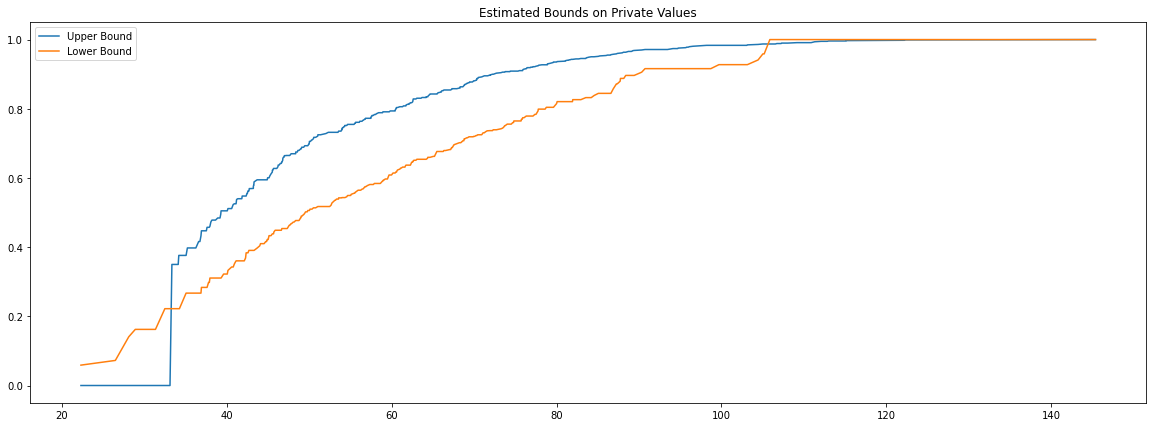

In [244]:
plt.plot(sorted_prices, V_U, label = 'Upper Bound')
plt.plot(sorted_prices, V_L, label = 'Lower Bound')
plt.title('Estimated Bounds on Private Values')
plt.legend()
plt.show()

## Question 3
___
#### Part (a)

We will estimate following Li, Perrigne, Vuong (2002). Using this identification procedure, we use a two-step estimator. In the first step, if we simplify for our case of 500 4-bidder auctions,

$$\hat{G}_{B_1,b_1}(B,b) = \frac{1}{2000 h_G}\sum_{\ell=1}^{500}\sum_{i=1}^4\mathbb{1}\{B_{i\ell}\leq B)K_G\left(\frac{b-b_{i\ell}}{h_G}\right)$$
$$\hat{g}_{B_1,b_1}(B,b) = \frac{1}{2000 h_g^2}\sum_{\ell=1}^{500}\sum_{i=1}^4K_g\left(\frac{B-B_{i\ell}}{h_g}\right)K_g\left(\frac{b-b_{i\ell}}{h_g}\right)$$
where $b$ is the bid of player $i$ and $B$ is the first-order statistic of the other bids. With these estimates, values can be computed as
$$v_i(b_i) = b_i + \frac{\hat{G}_{B,b}(b_i,b_i)}{\hat{g}_{B,b}(b_i,b_i)}$$
In the second step, these values represent a pseudo-sample, and can be used to obtain a non-parametric joint density function:
$$\textbf{f}(v_1,...,v_4) = \frac{1}{500h_f^4}\sum_{i=1}^{500}\prod_{\ell=1}^4K_f\left(\frac{v_{\ell}-\hat{v}_{i\ell}}{h_f}\right)$$

To obtain the nonparametric estimates, we use the triweight kernel with $n=2$:
$$K_g(u) = K_G(u) = \frac{35}{32}\left(1-u^2\right)^3\mathbb{1}\{|u| \leq 1\}$$
For kernels, we use (as $n=4$)
$$h_G = c_G(nL)^{-1/9}\quad h_g=c_g(nL)^{-1/10}$$
with
$$c_g = c_G = 2.978 \times 1.06\hat{\sigma}_b$$
where $\hat{\sigma}_b$ is the standard deviation of the bids. In the second stage, we take
$$h_f = c_f(4!L_T)^{-1/17}$$
where
$$c_f = 2.978 \times 1.06\hat{\sigma}_T$$
where subscript $T$ variables indicate those used after trimming. The trimming that is utilized restricts us to consider bids $b_i$ where
$$h_g \leq b_{i\ell} \leq b_{max} - h_g$$
However, using our data, we drop all observations if we trim, so we will not trim the values in this case.

In [247]:
data_og = np.loadtxt(source_path.format('fpa'))

In [530]:
L,n = data_og.shape
bids = data_og.reshape(-1)
sigma_b = np.std(bids, ddof=1)
h_G = 2.978 * 1.06 * sigma_b * (n*L) ** (-1./9.)
h_g = 2.978 * 1.06 * sigma_b * (n*L) ** (-1./10.)
h_f = 2.978 * 1.06 * sigma_b * (n*L) ** (-1./17.)
L_T = L

b_i = bids.copy()
# to get first order statistic, we repeat each observation four times, 
# make the ith bid 0, and compute the max
repeated_bids = np.repeat(data_og, n, axis = 0)
B_i = np.max(repeated_bids - np.tile(np.eye(n), (L,1)) * repeated_bids, axis = 1)

# apply trimming by removing auctions with extreme values
b_max = np.max(bids)
trim_idx = np.sum((data_og >= h_g) * (data_og <= b_max - h_g), axis = 1) == 4.
data_trim = data_og[trim_idx]

def K(u):
    return((35/32) * (1-u**2)**3 * (np.abs(u) <= 1))

def G_hat(B,b):
    val = 1./(L*n*h_G) * np.sum((B_i <= B) * K((b-b_i) / h_G))
    return(val)

def g_hat(B,b):
    val = 1./(L*n*h_g**2) * np.sum(K((B-B_i) / h_g) * K((b-b_i) / h_g))
    return(val)
    
def v(b):
    return(b + G_hat(b,b) / g_hat(b,b))

values = np.array([v(x) for x in bids]).reshape(L_T,n)
value_combos = np.row_stack([np.array(list(set(permutations(values[i])))) for i in range(len(values))])

def f_hat(v):
    frac = 1. / (24. * L_T * h_f**4) 
    v_mat = np.repeat(v.reshape(1,-1), len(value_combos), axis = 0)
    K_vals = K((v_mat - value_combos) / h_f)
    return(frac * np.sum(np.prod(K_vals, axis = 1)))

def f_hat_marg(v):
    frac = 1. / (4. * L_T * h_f) 
    K_vals = K((v - values.reshape(-1)) / h_f)
    return(frac * np.sum(K_vals))

We get the 25$^{th}$ and 75$^{th}$ percentiles of the bids, as we know that this will map to the corresponding percentiles of the value functions, since the transformation is monotonic.

In [434]:
perc_25_v = v(np.percentile(bids, 25))
perc_75_v = v(np.percentile(bids, 75))
perc_25_v, perc_75_v

(42.337171700689865, 150.49606789638602)

In [501]:
all_combos = np.array(np.meshgrid([perc_75_v,perc_25_v],
                                  [perc_75_v,perc_25_v],
                                  [perc_75_v,perc_25_v],
                                  [perc_75_v,perc_25_v])).T.reshape(-1,4)

In [486]:
def emp_cdf_4(u_i):
    return(np.sum(np.sum(values <= np.array(u_i), axis = 1) == 4) / len(values))

In [521]:
est_cdf = np.array([emp_cdf_4(all_combos[i]) for i in range(len(all_combos))])
output_table = pd.DataFrame(np.column_stack([all_combos, est_cdf, np.sum(all_combos == perc_75_v, axis = 1)]))

output_table.sort_values([5,0,1,2,3], ascending=[False] + [True]*4, inplace=True)
output_table[6] = .75 ** output_table[5] * .25 ** (4.-output_table[5])
output_table.drop(5, axis = 1, inplace=True)
output_table.rename({0: 'u_1', 1: 'u_2', 2: 'u_3', 3: 'u_4', 4: 'F_U', 6: 'F_Ind'}, axis = 1)

,u_1,u_2,u_3,u_4,F_U,F_Ind
0,150.496068,150.496068,150.496068,150.496068,0.308,0.316406
2,42.337172,150.496068,150.496068,150.496068,0.092,0.105469
1,150.496068,42.337172,150.496068,150.496068,0.102,0.105469
4,150.496068,150.496068,42.337172,150.496068,0.104,0.105469
8,150.496068,150.496068,150.496068,42.337172,0.106,0.105469
3,42.337172,42.337172,150.496068,150.496068,0.022,0.035156
6,42.337172,150.496068,42.337172,150.496068,0.024,0.035156
10,42.337172,150.496068,150.496068,42.337172,0.028,0.035156
5,150.496068,42.337172,42.337172,150.496068,0.046,0.035156
9,150.496068,42.337172,150.496068,42.337172,0.038,0.035156


We can also produce summary statistics of the values by bidder:

In [529]:
pd.DataFrame(values).describe()

,0,1,2,3
count,500.000000,500.000000,500.000000,500.000000
mean,107.160760,102.280138,102.117587,104.172485
std,68.960217,72.657828,69.481415,71.699837
min,0.451375,0.007530,0.189677,0.193711
25%,49.157831,38.063638,42.724698,40.715718
50%,103.392636,96.316114,99.649484,99.551525
75%,153.140518,145.051427,146.104960,156.423842
max,277.944519,279.513275,275.945204,279.816103


The distributions of the values do look different, where the mean of bidders 1 and 4 appears to be higher than the means of bidders 2 and 3. Further, the medians are very disparate across the bidders. Finally, the paper does give the PDF and the marginal PDF for any set of values, so we can compare these to test for independence.

In [547]:
joint = np.array([f_hat(values[x]) for x in range(len(values))])
marg = np.prod(np.array([f_hat_marg(x) for x in values.reshape(-1)]).reshape(L_T, n), axis = 1)
ratio = joint / marg
pd.DataFrame(ratio).describe()

,0
count,500.000000
mean,1.051429
std,0.267972
min,0.641157
25%,0.980757
50%,1.036622
75%,1.085689
max,6.179126


With a median value of 1.03 and a mean value of 1.05, the ratio of the joint distribution PDF to the product of the marginal value PDFs appears to be larger than 1 anecdotally, which would indicate that independence is less likely to hold.

#### Part (b)
For this one, we simply use the GPV methodology included in the notes.

In [523]:
L,I = data_og.shape
sigma_b = np.std(bids, ddof=1)
h_g = 1.06 * sigma_b * (I * L) ** (-1./5.)

def kernel(b, bids):
    u_i = (b - bids.reshape(-1)) / h_g
    return(np.sum((35/32) * (1-u_i**2)**3 * (np.abs(u_i) <= 1)) / (L * I * h_g))

In [524]:
def get_value(b):
    G_val = np.sum(data_og.reshape(-1,) <= b) / data_og.size
    g_val = kernel(b, data_og)
    return(b + G_val / (3 * g_val))

In [525]:
flat_bids = data_og.reshape(-1)
trimmed_bids = flat_bids[np.where((flat_bids <= flat_bids.max() - h_g) & (flat_bids >= flat_bids.min() + h_g))]
values = [get_value(b) for b in trimmed_bids.tolist()]
estimated_cdf = get_empirical_cdf(np.array(values))

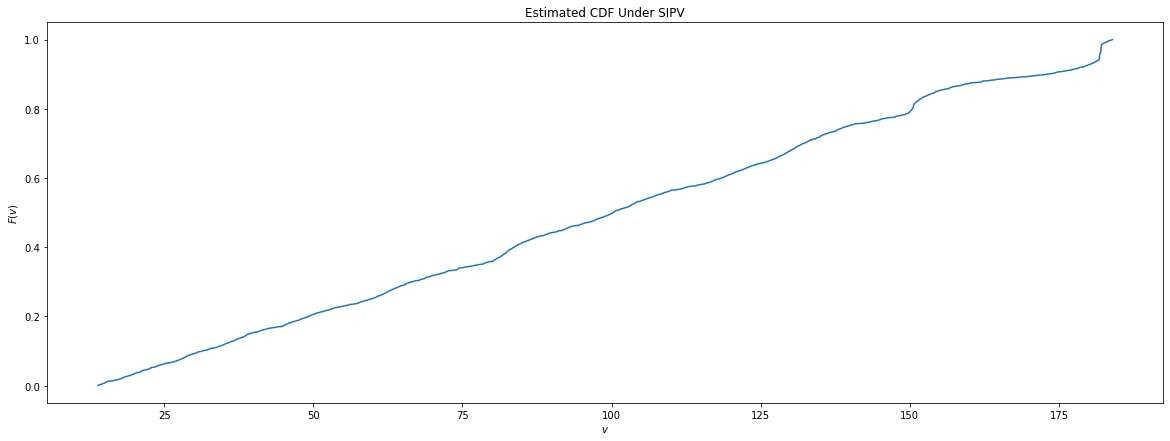

In [526]:
plt.plot(estimated_cdf[:,0], estimated_cdf[:,1])
plt.title('Estimated CDF Under SIPV')
plt.xlabel('$v$')
plt.ylabel('$F(v)$')
plt.show()